In [1]:
import cv2
import os
import numpy as np
from random import shuffle

In [2]:
TRAIN_DIR = '/Users/mackenzieboudreau/Downloads/train'
TEST_DIR = '/Users/mackenzieboudreau/Downloads/test'
IMG_SIZE = 50
LR = 1e-3 

MODEL_NAME = 'dogsvscat:{}:{}.model'.format(LR, '6conv-improv')


In [3]:
def labelImg(img):
    word_label = img.split('.')[-3]
    if (word_label == 'cat'): return [1,0]
    elif (word_label == 'dog'): return [0, 1]
    
def create_train_data():
    train_data = []
    i = 0
    j = 10
    for img in os.listdir(TRAIN_DIR):
        i += 1
        if (i % 2500 == 0):
            print(str(j) + "% DONE")
            j += 10
        label = labelImg(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        train_data.append([np.array(img), np.array(label)])
    shuffle(train_data)
    np.save('train_data.npy', train_data)
    return train_data

In [4]:
def process_test_data():
    testing_data = []
    for img in os.listdir(TEST_DIR):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        testing_data.append([np.array(img), np.array(img_num)])
    np.save('test_comp.npy', testing_data)
    return testing_data

In [5]:
train_data = np.load('train_data.npy')

In [6]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf

tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [11]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')


In [8]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [9]:
# model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
#     snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
# model.save('{}.meta'.format(MODEL_NAME))

Training Step: 3829  | total loss: 0.27890 | time: 88.337s
| Adam | epoch: 010 | loss: 0.27890 - acc: 0.8764 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.28820 | time: 89.573s
| Adam | epoch: 010 | loss: 0.28820 - acc: 0.8747 | val_loss: 0.55983 - val_acc: 0.7680 -- iter: 24500/24500
--
INFO:tensorflow:/Users/mackenzieboudreau/dev/ml/notebook/dogsvscat:0.001:6conv-improv.model.meta is not in all_model_checkpoint_paths. Manually adding it.


[ 0.24509335  0.75490665]
[ 0.98838717  0.01161288]
[ 0.91151482  0.08848516]
[ 0.08685792  0.91314209]
[ 0.10399878  0.89600122]
[ 0.9979924   0.00200767]
[ 0.93938851  0.06061151]
[ 0.00867165  0.99132842]
[ 0.01320314  0.98679686]
[ 0.99896657  0.00103338]
[ 0.73048723  0.26951271]
[ 0.98778605  0.01221393]
[ 0.96332777  0.03667225]
[ 0.85911071  0.14088923]
[ 0.07035246  0.92964756]
[  3.11930518e-04   9.99688148e-01]
[ 0.14169884  0.85830116]
[ 0.9964658  0.0035342]
[ 0.98001993  0.0199801 ]
[ 0.98382574  0.01617427]


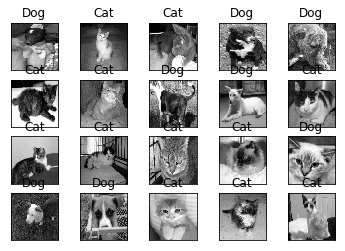

In [10]:
import matplotlib.pyplot as plt

# if you don't have this file yet
test_data = np.load('test_comp.npy')

fig = plt.figure()

for num, data in enumerate(test_data[:20]):
    # cat = [1, 0]
    # dog = [0, 1]
    img_num = data[1]
    img_data = data[0]
    
    
    y = fig.add_subplot(4,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    print(model_out)
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
    
    
    
    